In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/Paradox3333/Transformers-from-scratch/master/names.txt

--2024-09-09 16:35:49--  https://raw.githubusercontent.com/Paradox3333/Transformers-from-scratch/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-09-09 16:35:49 (8.67 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch] # convert char to index
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [8]:
max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # sample random row indices
    Xb, Yb = Xtr[ix], Ytr[ix]   # batch X,Y of char indices

    # Forward pass
    emb = C[Xb]                             # embed the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1)    # concatenate the vectors
    h_pre_act = emb_cat @ W1 + b1           # hidden layer pre-activation
    h = torch.tanh(h_pre_act)               # hidden layer
    logits = h @ W2 + b2                    # output layer
    loss = F.cross_entropy(logits, Yb)      # loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    if i  % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.9415
  20000/ 200000: 2.5069
  30000/ 200000: 2.7998
  40000/ 200000: 2.0261
  50000/ 200000: 2.5863
  60000/ 200000: 2.3420
  70000/ 200000: 2.0952
  80000/ 200000: 2.3454
  90000/ 200000: 2.2365
 100000/ 200000: 2.1080
 110000/ 200000: 2.3831
 120000/ 200000: 1.9898
 130000/ 200000: 2.4591
 140000/ 200000: 2.1910
 150000/ 200000: 2.1606
 160000/ 200000: 2.1811
 170000/ 200000: 1.7997
 180000/ 200000: 2.0962
 190000/ 200000: 1.8052


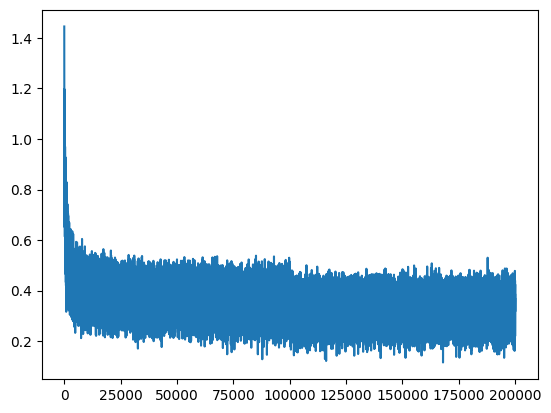

In [9]:
plt.plot(loss_i)

In [10]:
@torch.no_grad()    # temporarily turns off gradient computation for the next function
                    # Makes the code more efficient since Pytorch does not have to maintain the computational graph for gradient calc

def split_loss(split: str) -> None:
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # index into the dictionary to select what to evaluate based on function call

    #Forward pass
    emb = C[x]                              # (N, block_size, n_embd)
    emb_cat = emb.view(emb.shape[0], -1)    # concat into (N, block_size * n_embd)
    h = torch.tanh(emb_cat @ W1 + b1)       # (N, n_hidden)
    logits = h @ W2 + b2                    # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.127678871154785
val 2.1750576496124268


In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d) because it's 1 example being generated, every forward pass adds a prediction until . is hit
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() # sample from predicted probability distribution over the characters
      context = context[1:] + [ix] # shift context
      out.append(ix) # append index of predicted character
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # convert indices to characters and print

mora.
mayah.
seel.
nehayla.
remyra.
endrael.
adeer.
melin.
shy.
jen.
ede.
seananaraelyn.
malya.
cayshubergiaghan.
trickontelionnie.
cayus.
mace.
ryyah.
fael.
youe.


In [12]:
# Issues:

# 1) The loss at initialization is not appropriate:
#    first 10k training steps loss:
#                     0/ 200000: 27.8817
#                     10000/ 200000: 2.7955
#
#  We expect the model to predict all characters with equal probability when it hasn't learned
#  anything yet. This means a p of 1/27.0. And the associated loss is:
print(f'{-torch.tensor(1/27.0).log() = }')

# Note: if instead we correctly initialize the weights (around 0 but with some entropy to break symmetry) and biases (to 0),
#       the first 10k iterations can be used to actually learn something, yielding better performance of the NN after all training is done.

# 2) if too many activations fed into the tanh are too large, the tanh will respond in the same way (with -1 or 1, remember tanh graph),
#    this causes gradients to vanish, which can result in dead neurons that never learn (their weights and biases are never learning)!
#       Remember summary of grad calc Steps:
#           Compute the forward pass with y = tanh(x).
#           During backpropagation, receive the gradient of the loss with respect to the output of the tanh function, dL/dy.
#           Compute the derivative of the tanh function: dy/dx = 1 - tanh^2(x) = 1 - y^2.
#           Apply the chain rule: dL/dx = dL/dy * (1 - y^2).
#    https://www.youtube.com/watch?v=P6sfmUTpUmc&t=144s (00:12:59 - 00:27:53)

-torch.tensor(1/27.0).log() = tensor(3.2958)


### Distributions optimization

In [ ]:
# Initialize
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# In modern NNs the most practical initialization to ensure normal distribution of parameters is with a gain of sqrt(fan_in) with fan_in being the number of
# inputs.

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # Kaiming initialization with gain for tanh nonlinearity.
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [14]:
max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # sample random row indices
    Xb, Yb = Xtr[ix], Ytr[ix]   # batch X,Y of char indices

    # Forward pass
    emb = C[Xb]                             # embed the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1)    # concatenate the vectors
    h_pre_act = emb_cat @ W1 + b1           # hidden layer pre-activation
    h = torch.tanh(h_pre_act)               # hidden layer
    logits = h @ W2 + b2                    # output layer
    loss = F.cross_entropy(logits, Yb)      # loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    if i  % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


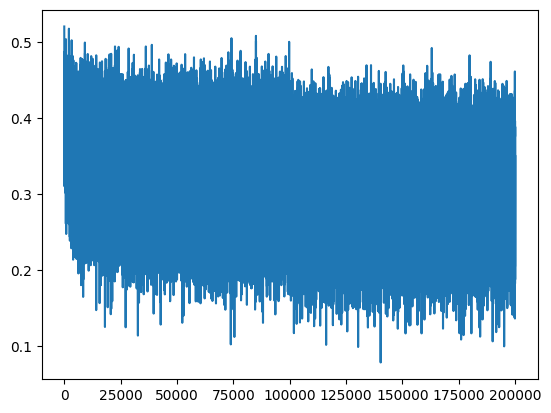

In [15]:
plt.plot(loss_i)

In [16]:
@torch.no_grad()    # temporarily turns off gradient computation for the next function
                    # Makes the code more efficient since Pytorch does not have to maintain the computational graph for gradient calc

def split_loss(split: str) -> None:
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # index into the dictionary to select what to evaluate based on function call

    #Forward pass
    emb = C[x]                              # (N, block_size, n_embd)
    emb_cat = emb.view(emb.shape[0], -1)    # concat into (N, block_size * n_embd)
    h = torch.tanh(emb_cat @ W1 + b1)       # (N, n_hidden)
    logits = h @ W2 + b2                    # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

# Note: Loss is much better.

train 2.0376641750335693
val 2.106989622116089


## Batch Norm

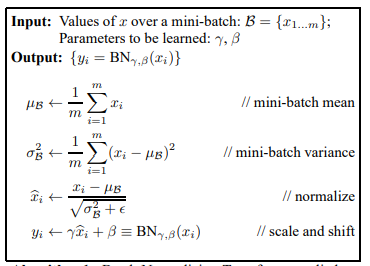

In [ ]:
# Initialize
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size**0.5)) # Kaiming initialization

# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
# Note: z - μ = (W * x + b) - mean(W * x + b) = (W * x + b) - [mean(W * x) + b] = (W * x) - mean(W * x)
#       This is important because when we subtract the mean μ during BatchNorm, we effectively remove this shift.
#       The bias β directly shifts the mean of the pre-activation output z.
#       Therefore, the batch norm biases (which are per neuron) can take on the role of neuron biases.
#
#       BatchNorm scaling: z_BN(i,j) = γ_j * z_hat(i, j) + β_j     ,     with i = ith batch sample and j = jth neuron.
#
#       On the other hand, The scaling factor γ (gamma) in BatchNorm does not replace the weights W because they serve different purposes.
#       The weights W learn the relationships between inputs and outputs (i.e., the core pattern learning in the network), while
#       γ adjusts the scale of the output after normalization to ensure effective training without interfering with the weights' role in
#       learning features. (biases are 1 per neuron, just like in BatchNorm, but weights are n_inputs per neuron, unlike the scaling factor γ,
#       which is 1 per neuron as well. Remember W is a matrix and b a vector.).

W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# So batch norm does 2 things:
# 1. Normalize preactivations for good behavior at initialization.
# 2. Still give the NN the ability to learn how to best shape its preactivation distributions via bngain and bnbias.

# Batch norm parameters.
bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

bnmean_running = torch.zeros(1, n_hidden)   # Tracking instead of calculating them over the whole training set at the end.
                                            # Needed because, with batchnorm, the network now expects batches to be able to calculate batch statistics.
bnstd_running = torch.ones(1, n_hidden)     # Initialized to 1s since h_pre_act will be roughly unit gaussian as per initialization

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [ ]:
max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # sample random row indices
    Xb, Yb = Xtr[ix], Ytr[ix]   # batch X,Y of char indices

    # Forward pass
    emb = C[Xb]                             # embed the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1)    # concatenate the vectors
    h_pre_act = emb_cat @ W1 # + b1         # hidden layer pre-activation

    # Batch norm layer.
    # ------------------------------------------------------------------------------------------------------------------------------
    bnmeani = h_pre_act.mean(0, keepdim=True)
    bnstdi = h_pre_act.std(0, keepdim=True)

    h_pre_act = bngain * ((h_pre_act - bnmeani) / bnstdi) + bnbias # bnbias takes on the function of the neuron biases.

    with torch.no_grad():   # Tell pytorch these are not to be backprop through and should not be added to the computational graph.
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # ------------------------------------------------------------------------------------------------------------------------------
    h = torch.tanh(h_pre_act)               # hidden layer activation
    logits = h @ W2 + b2                    # output layer

    loss = F.cross_entropy(logits, Yb)      # loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    if i  % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.1029
  20000/ 200000: 2.5859
  30000/ 200000: 1.9663
  40000/ 200000: 2.2720
  50000/ 200000: 1.7952
  60000/ 200000: 2.1208
  70000/ 200000: 2.3775
  80000/ 200000: 2.4205
  90000/ 200000: 2.0829
 100000/ 200000: 2.3486
 110000/ 200000: 2.3512
 120000/ 200000: 1.6859
 130000/ 200000: 1.9948
 140000/ 200000: 2.2430
 150000/ 200000: 2.0044
 160000/ 200000: 2.0956
 170000/ 200000: 2.4032
 180000/ 200000: 2.0609
 190000/ 200000: 2.0705


In [19]:
h_pre_act.mean(0, keepdim=True).shape # mean and std are calculated PER NEURON!

torch.Size([1, 200])

In [20]:
# Problem: The NN now expects batches so it can compute batch statistics, but at inference time we might want just one output.

# Therefore, we estimate bnmean and bnstd at the end, and these values will be used at inference time.

# with torch.no_grad():
    # pass the training set through
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     h_pre_act = embcat @ W1 + b1

    # Measure the traning set mean and std (remember emb was taken from the whole Xtr)
#     bnmean = h_pre_act.mean(0, keepdim=True)
#     bnstd = h_pre_act.std(0, keepdim=True)

# But in a better way, we can instead just keep track of the mean and std as we train.

In [ ]:
@torch.no_grad()    # Temporarily turns off gradient computation for the next function.
                    # Makes the code more efficient since Pytorch does not have to maintain the computational graph for gradient calc

def split_loss(split: str) -> None:
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # index into the dictionary to select what to evaluate based on function call

    #Forward pass
    emb = C[x]                              # (N, block_size, n_embd)
    emb_cat = emb.view(emb.shape[0], -1)    # concat into (N, block_size * n_embd)
    h_pre_act = emb_cat @ W1 # + b1         # (N, n_hidden)

    h_pre_act = bngain * ((h_pre_act - bnmean_running) / bnstd_running) + bnbias # Batch norm layer with running statistics for inference

    h = torch.tanh(h_pre_act)               # (N, n_hidden)
    logits = h @ W2 + b2                    # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0596511363983154
val 2.1066300868988037


In [22]:
print(f'{emb.shape = }, \n{emb_cat.shape = }, \n{W1.shape = }, \n{h_pre_act.shape = }, \n{h.shape = }, \n{logits.shape = }')

emb.shape = torch.Size([32, 3, 10]), 
emb_cat.shape = torch.Size([32, 30]), 
W1.shape = torch.Size([30, 200]), 
h_pre_act.shape = torch.Size([32, 200]), 
h.shape = torch.Size([32, 200]), 
logits.shape = torch.Size([32, 27])


## Code cleanup with classes and functions

In [ ]:
class Linear:

    def __init__(self, fan_in: int, fan_out: int, bias: bool =True) -> None:
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = x @ self.weight
        if self.bias is not None:   # The 'is' and 'is not' operators check object identity, meaning they determine whether two references point to
                                    # the exact same object in memory.

                                    # == and !=, on the other hand, check object equality, meaning they determine whether the values of two
                                    # objects are equal, regardless of whether they are the same object in memory.
            self.out += self.bias
        return self.out

    def parameters(self) -> list:
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim: int, eps: float = 1e-05, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.tensor) -> torch.tensor:
        # Forward pass
        if self.training:
            xmean = x.mean(0, keepdim= True)
            xvar = x.var(0, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self) -> list:
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = torch.tanh(x)
        return self.out

    def parameters(self) -> list:
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn(vocab_size, n_embd,                 generator=g) # random embeds

layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),  # (10*3, 100)
    Linear(           n_hidden, n_hidden), Tanh(),  # (100, 100)
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),        # (100, 27)
]

with torch.no_grad():
    # Last layer: make less confident (remember that multiplication and division affect the variance of a distribution through compression or expansion)
    layers[-1].weight *= 0.1
    # All other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

46497


In [ ]:
# Training

max_steps = 200000
batch_size = 32
loss_i = []

update_data_ratio = []

for i in range(max_steps):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # sample random row indices
    Xb, Yb = Xtr[ix], Ytr[ix]   # Batch X,Y of char indices

    # Forward pass
    emb = C[Xb]                     # Embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # Concatenate the vectors
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)   # Loss function

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()     # Tell Pytorch to retain the gradients, for debugging/analysis

    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    if i  % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())
    with torch.no_grad():
        update_data_ratio.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # For debugging

      0/ 200000: 3.2962


## Visualizations

layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


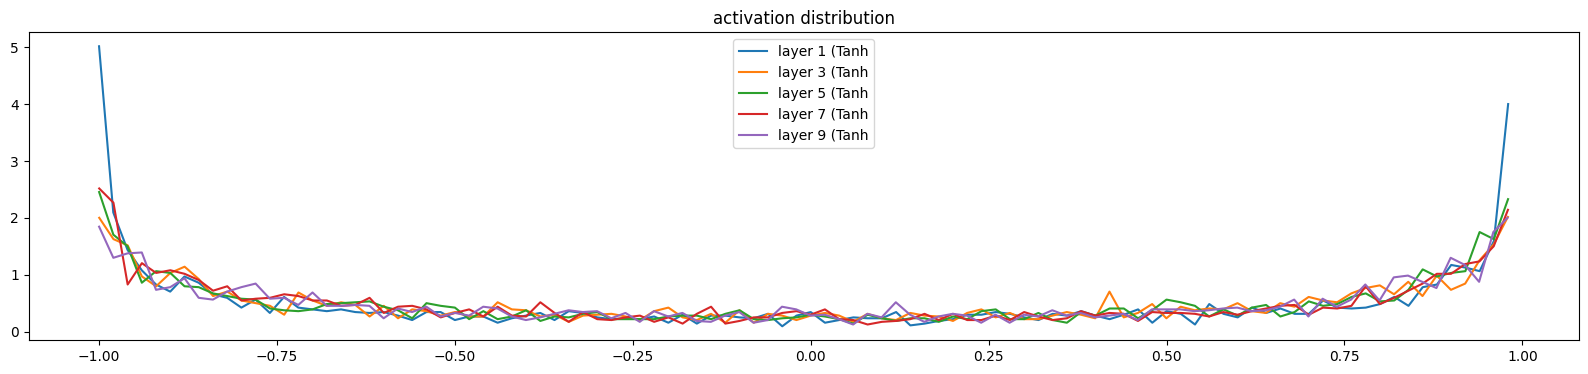

In [ ]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # Use enumerate so you can use the index of each layer and exclude the last layer.
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%'
              % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100)) # C-style string formatting.
        # __class__ returns the class object (verbose), __name__ returns the class name as a string.
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach()) # remove link to the autograd graph so Pytorch doesn't track this operation for no reason.
                                                # note that .detach() creates a copy of the referenced tensor but without history.
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);    # ; used to skip unwanted output
plt.title('activation distribution');

# NOTE: The tanh functions compress the distributions of the activations.
# Multiple tanh layers then keep compressing the standard deviation of the distribution of activations,
# as the tanh function is almost linear near 0 but not fully, so it keeps mapping the values to smaller ones, leading to a convergence to 0.
# The 5/3 factor is used to fight against this compression.

layer 1 (      Tanh): mean +0.000024, std 3.353992e-03
layer 3 (      Tanh): mean +0.000012, std 3.157344e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


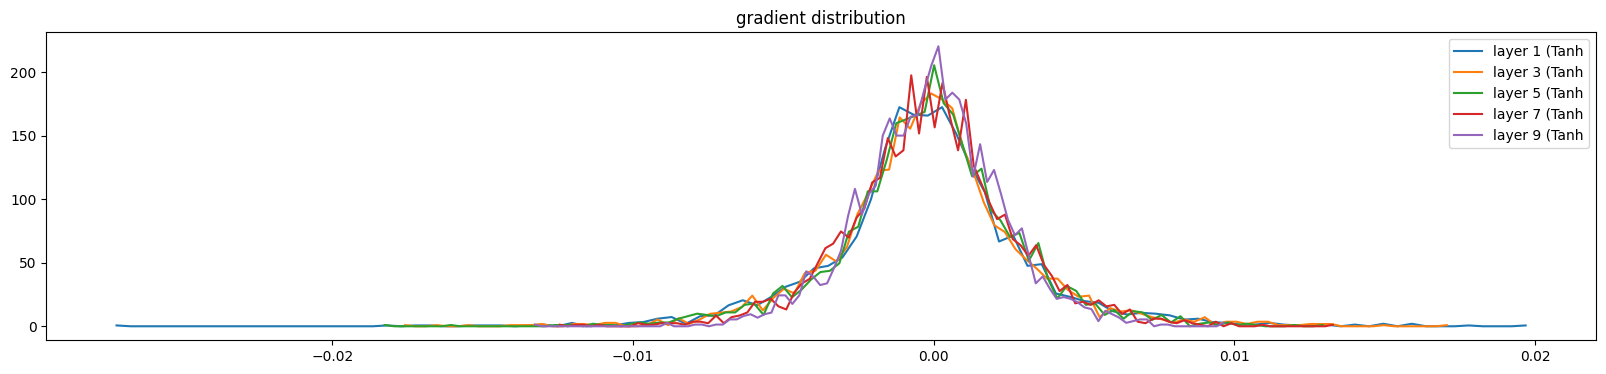

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution');

# NOTE: Gradients are not shrinking nor exploding deeper in the network, which is good.

weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214556e-02
weight (100, 100) | mean +0.000033 | std 7.821212e-03 | grad:data ratio 4.653362e-02
weight (100, 100) | mean -0.000107 | std 6.655620e-03 | grad:data ratio 3.925851e-02
weight (100, 100) | mean -0.000017 | std 6.086041e-03 | grad:data ratio 3.605768e-02
weight (100, 100) | mean -0.000077 | std 5.075620e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909910e-01


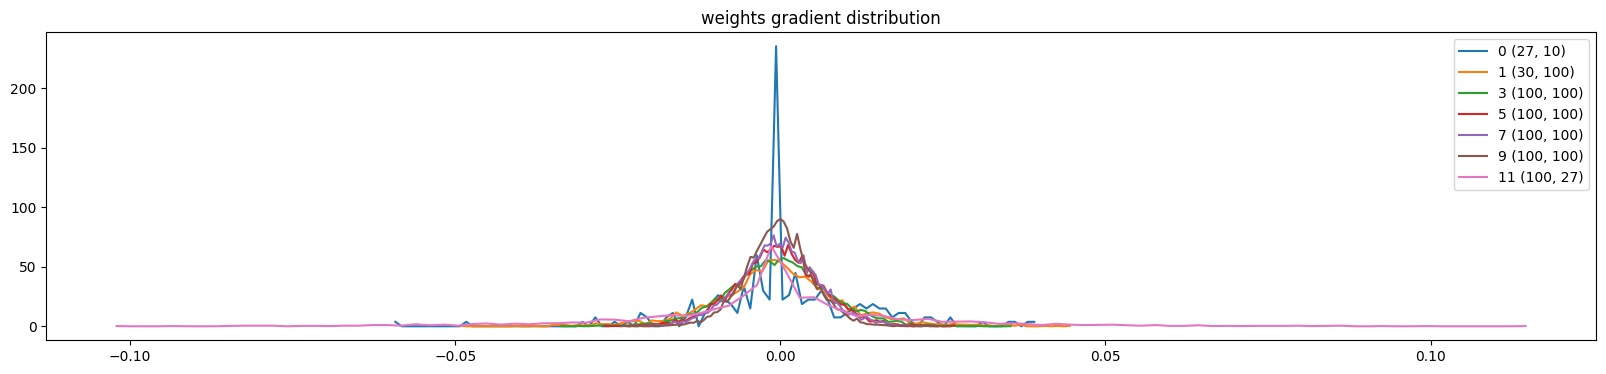

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # Restricting to only the W matrices
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' 
          % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    # NOTE: The grad:data ratio can be useful because the params are updates via the grads, so we need to have a sense of this scale.
    # TLDR: We want this to be small.
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

# NOTE: the std of the last layer is much larger than the ones from the other layers.
# This effectively means that this layer is trying to learn much faster compared to the other ones. 

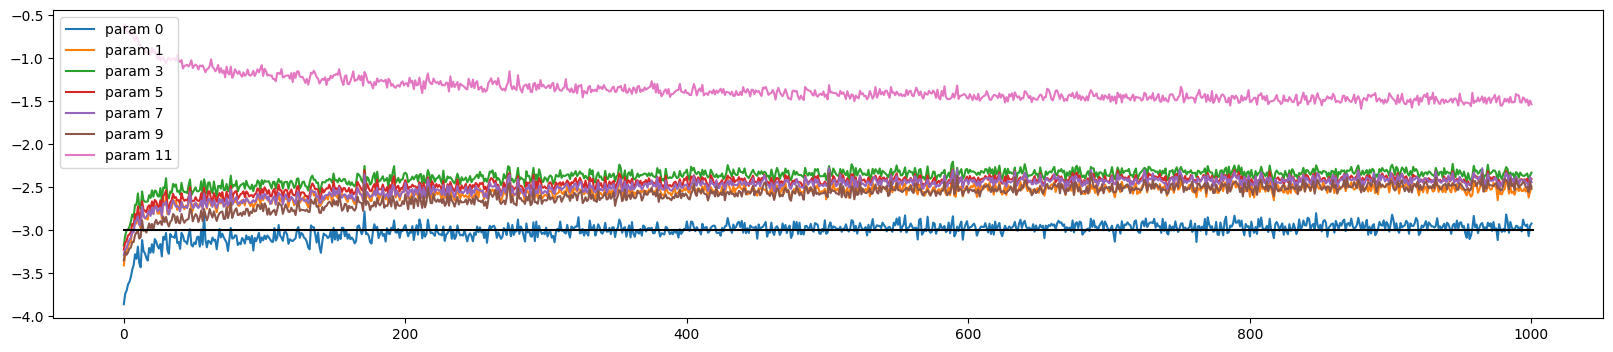

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([update_data_ratio[j][i] for j in range(len(update_data_ratio))])
    legends.append('param %d' % i)
plt.plot([0, len(update_data_ratio)], [-3, -3], 'k') # these ratios should be ~1e-3, indicated on plot w/ black line
plt.legend(legends);

# NOTE: This is a measure of how fast or slow the NN is learning. -> = feedback on chosen learning rates.
# Aim FOR 1e-3 in general!
# Meaning that we want the updates to the params to be around 1/1000th of the param values, and relatively uniform for all layers.

# The output layer is an outlier here because its params were artificially downsized at initialization,
# and this makes it so they need stronger updates at the start of training, but eventually stabilize as well.

## With batchnorm layers

In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  # Now, the code applies batch normalization, and gamma is essentially taking over the role of controlling the scale of the outputs for that layer.
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [30]:
# Training

max_steps = 200000
batch_size = 32
loss_i = []

update_data_ratio = []

for i in range(max_steps):

    # Minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # sample random row indices
    Xb, Yb = Xtr[ix], Ytr[ix]   # Batch X,Y of char indices

    # Forward pass
    emb = C[Xb]                     # Embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # Concatenate the vectors
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)   # Loss function

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()     # Tell Pytorch to retain the gradients

    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    if i  % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())

    with torch.no_grad():
        update_data_ratio.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # For debugging

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


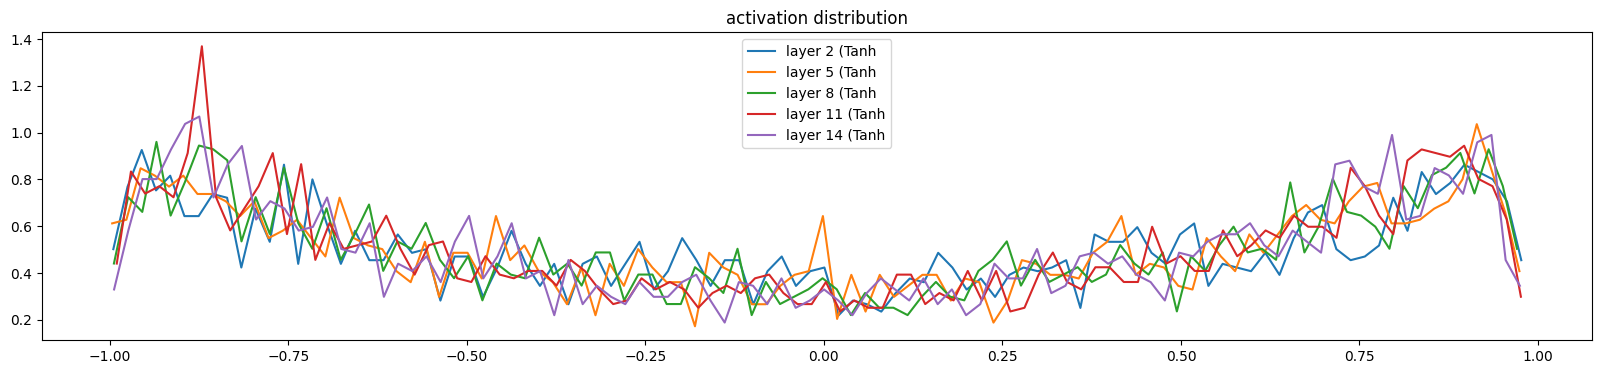

In [ ]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]): # Use enumerate so you can use the index of each layer and exclude the last layer.
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%'
              % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100)) # C-style string formatting.
        # __class__ returns the class object (verbose), __name__ returns the class name as a string.
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);    # ; used to skip unwanted output
plt.title('activation distribution');

# NOTE: Way lower saturation when using batch normalization.

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean -0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045741e-03
layer 11 (      Tanh): mean +0.000000, std 1.983133e-03
layer 14 (      Tanh): mean -0.000000, std 1.952381e-03


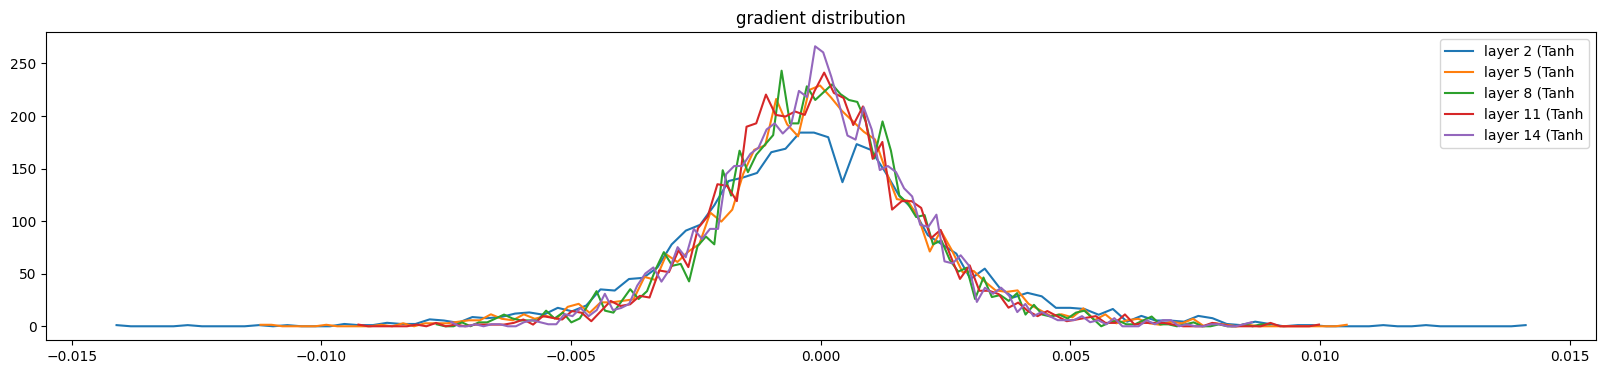

In [32]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean +0.000000 | std 8.020530e-03 | grad:data ratio 8.012626e-03
weight  (30, 100) | mean +0.000246 | std 9.241073e-03 | grad:data ratio 4.881089e-02
weight (100, 100) | mean +0.000113 | std 7.132873e-03 | grad:data ratio 6.964613e-02
weight (100, 100) | mean -0.000086 | std 6.234301e-03 | grad:data ratio 6.073737e-02
weight (100, 100) | mean +0.000052 | std 5.742181e-03 | grad:data ratio 5.631477e-02
weight (100, 100) | mean +0.000032 | std 5.672203e-03 | grad:data ratio 5.570123e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


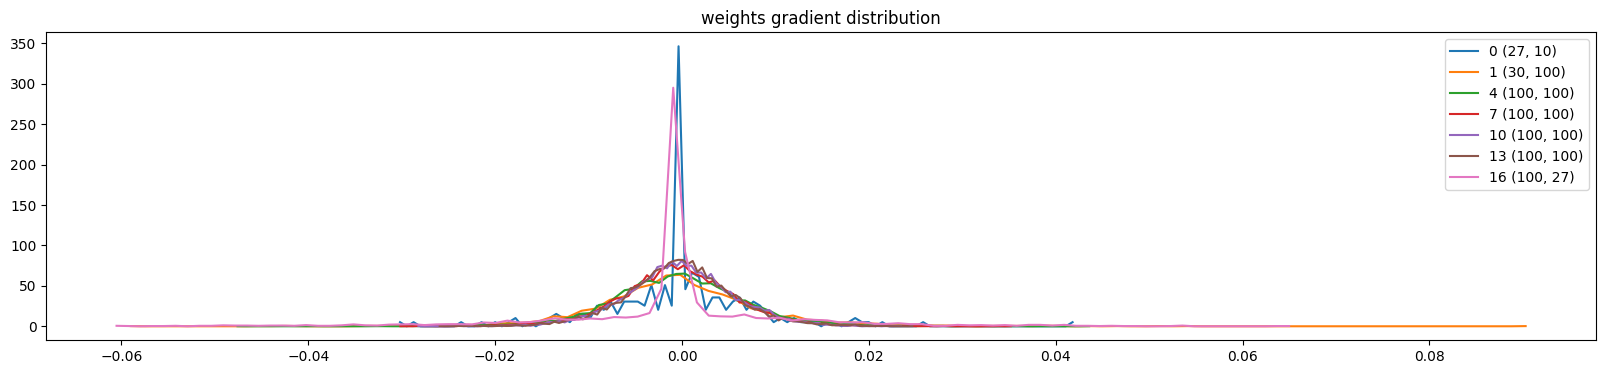

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # Restricting to only the W matrices
    print('weight %10s | mean %+f | std %e | grad:data ratio %e'
          % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution');

# NOTE: the std of the last layer is still much larger than the ones from the other layers

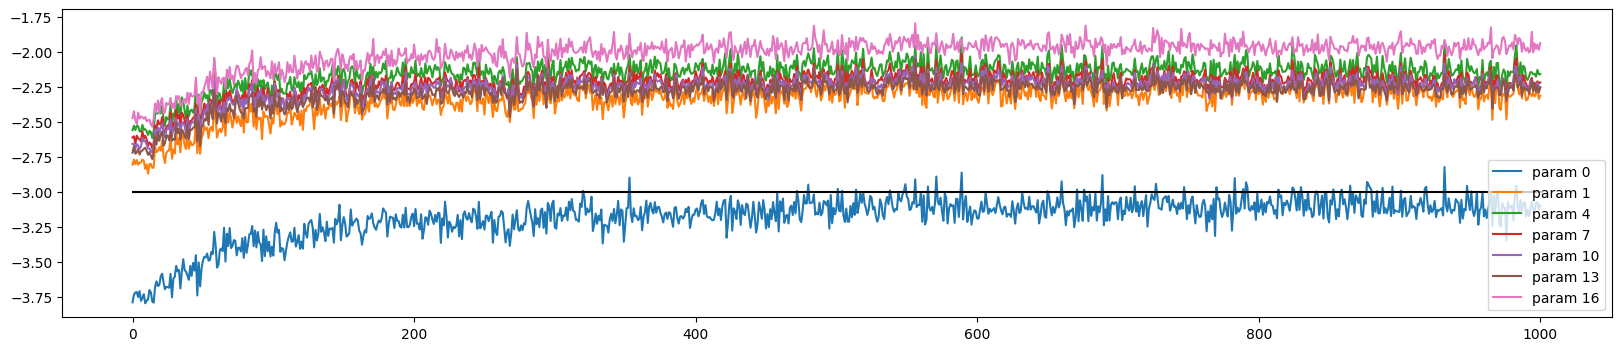

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([update_data_ratio[j][i] for j in range(len(update_data_ratio))])
    legends.append('param %d' % i)
plt.plot([0, len(update_data_ratio)], [-3, -3], 'k')
plt.legend(legends);

In [ ]:
# NOTE: Using batchNorm, we are more robust to the gains applied to the layers for initialization (Kaiming initialization / gain),
# but we need to still be careful with the lr to make sure that all weights are learning at similar rates and
# at an update/data ratio of around 1e-3 in the log10 scale, for example.

## Interactive exploration

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

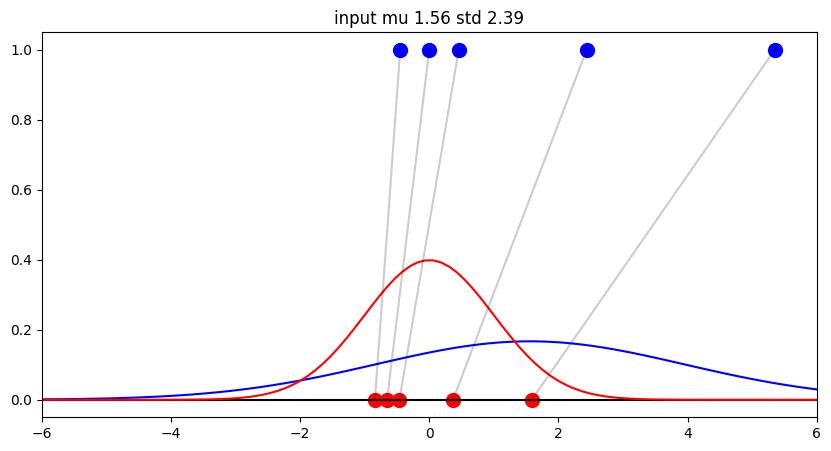

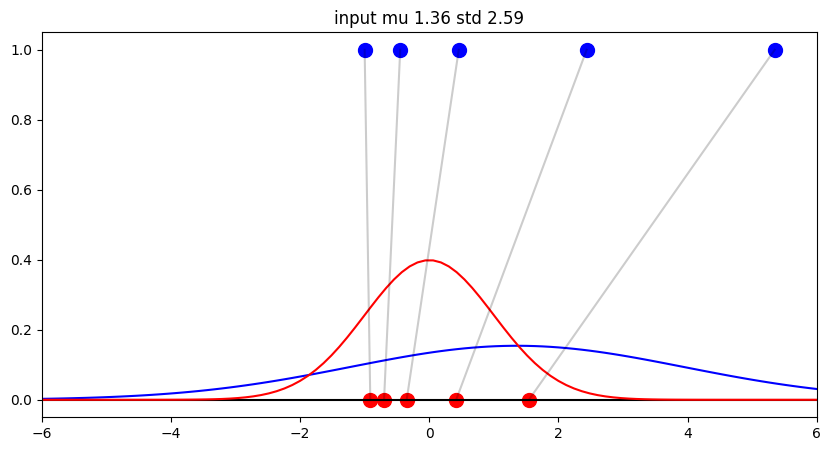

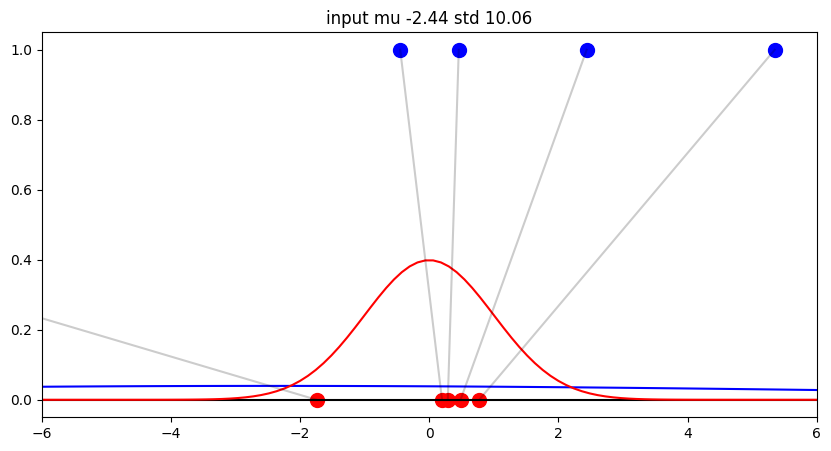

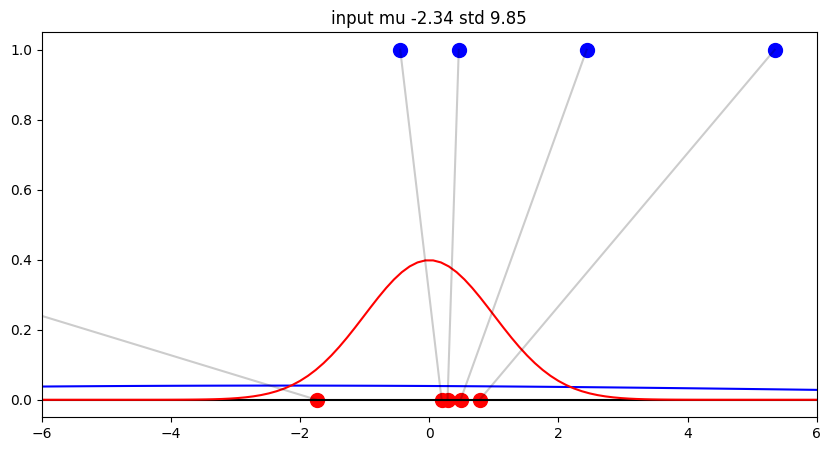

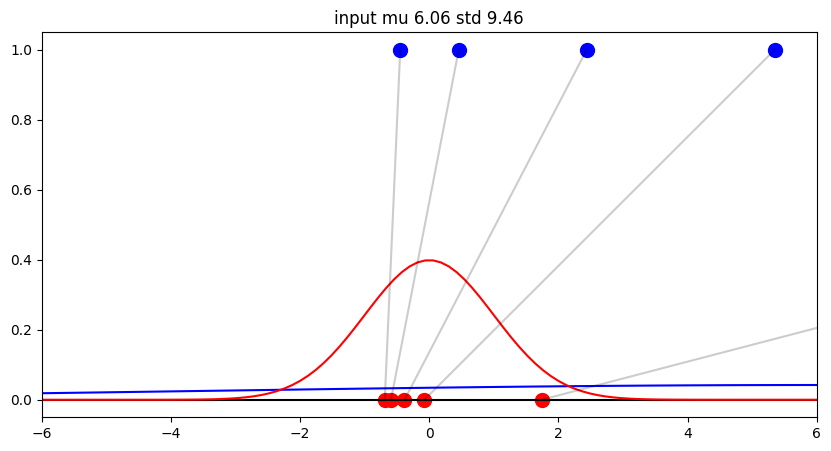

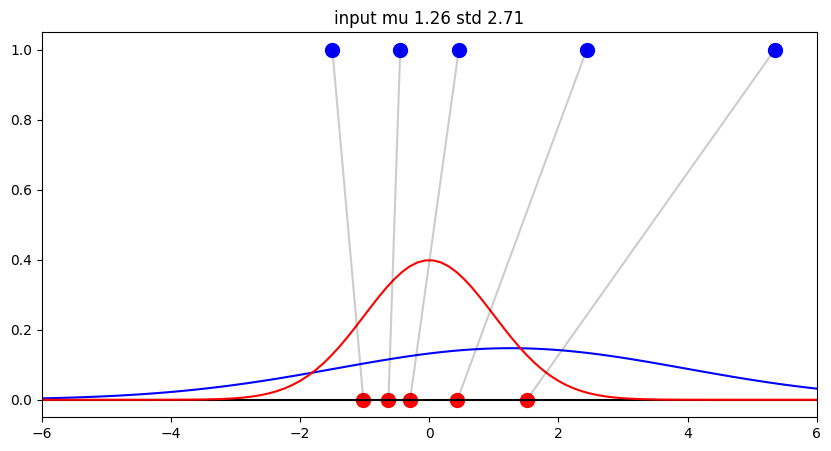

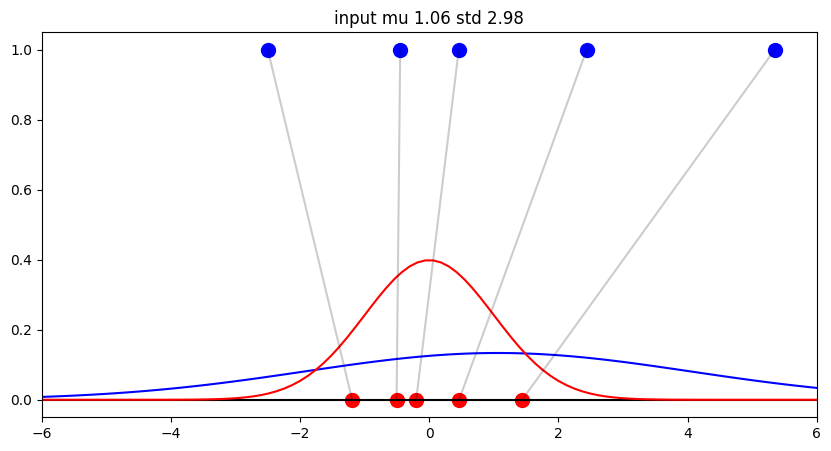

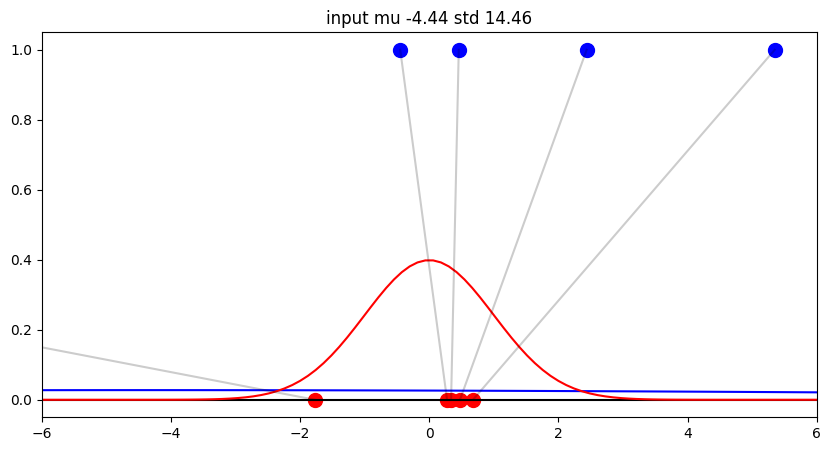

In [36]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):

  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig  # Normalization.

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)  # Plots the original input points (x) at y = 1 in blue.
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100) # Plots the normalized points (y) at y = 0 in red.
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));

In [ ]:
# Linear: activation statistics of forward and backward pass
'''
This code simulates a forward and backward pass in a simple linear operation and prints out the standard deviations (std) of
various activations and gradients during both passes.
'''
g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad (remember the chain rule)
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a # c.shape = (1000,1)
loss = torch.randn(1000, generator=g) @ c # Dummy loss to test how the gradients propagate.
a.retain_grad() # By default, intermediate variables (like c) will have their gradients cleared after backpropagation.
                # retain_grad() ensures that the gradients for a, b, and c are preserved after the backward pass for inspection.
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item()) # The result of the matrix multiplication, c = b @ a, has a large standard deviation (around 31) because it's the sum of many products.
print('-----')  # Gradients of the loss with respect to each of the elements (a, b, c).
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


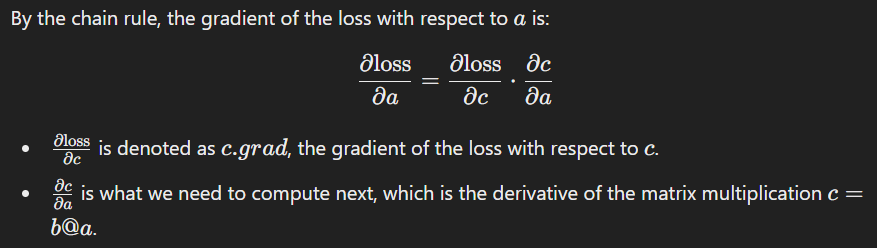

Reduced example:

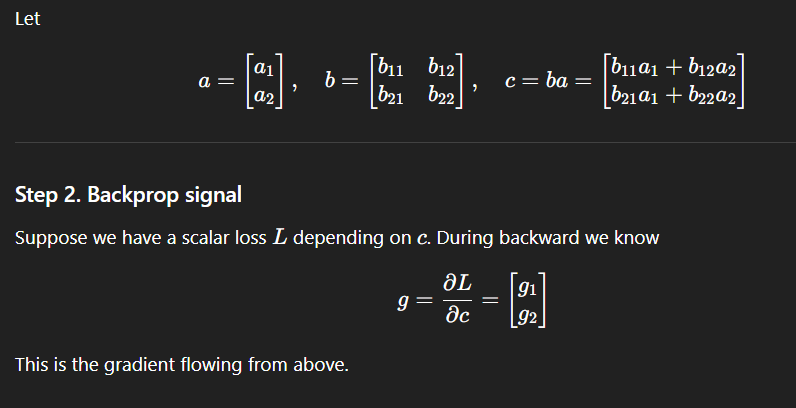

With dimensions as in the previous case the matrix multiplication can be written as:

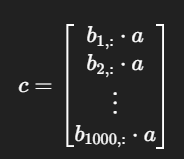

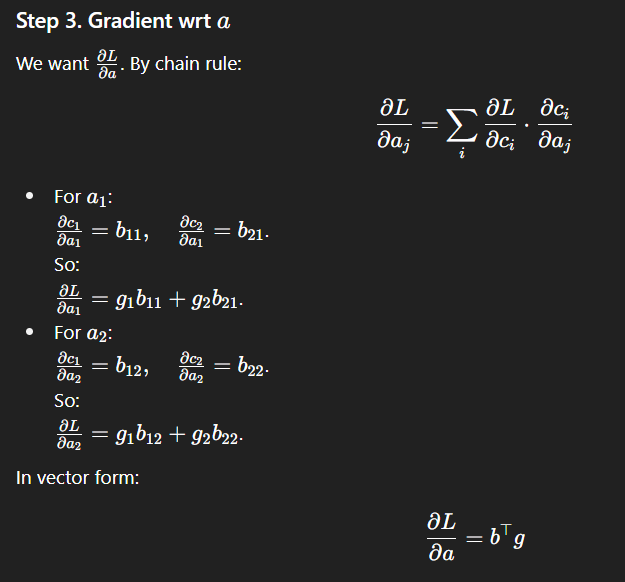

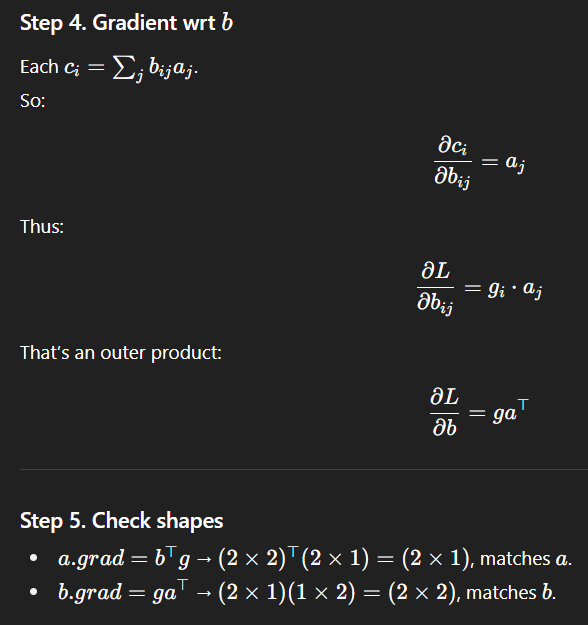

In [38]:
# Same thing as the above cell but wiith Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp # Output of linear layer
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())        # std of activations before BatchNorm.
print('out std: ', out.std().item())    # std of activations after BatchNorm.
print('------') 
print('out grad std: ', out.grad.std().item())  # ~1.0, BatchNorm has stabilized the gradient of "out".
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())      # ~0.03, This means that the weight updates during backpropagation will be small, which can help with training stability.
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559


In [ ]:
# NOTE: A std of 1 strikes a good balance between randomness (for diversity) and control (for stability).
# This is why we initialize weights from a standard normal distribution.

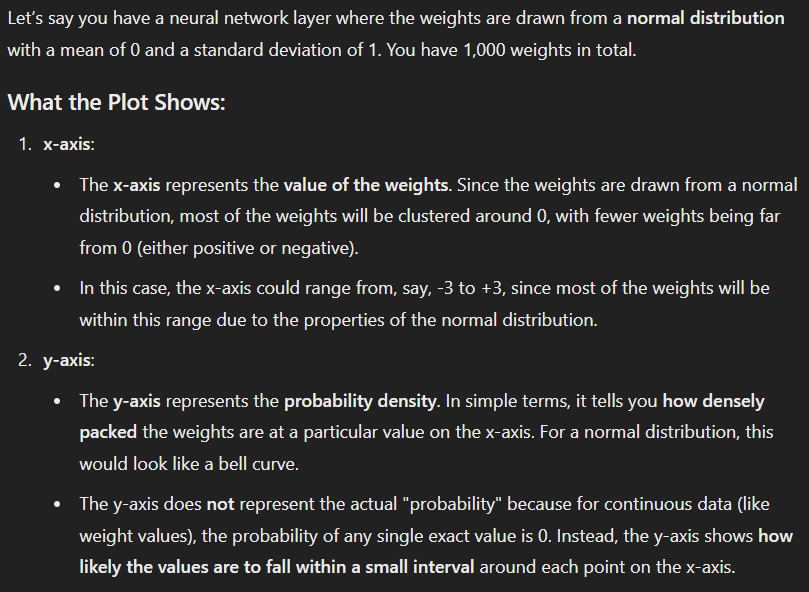

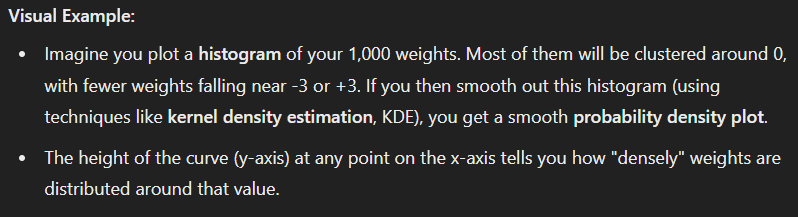

In [ ]:
# Note: 

# Update formula:           W_new = W_old + lr * -∂loss/∂W_old

# with: 
# ∂loss/∂W = ∂Wloss/∂a * ∂a/∂W
# a = activation
# W = weights

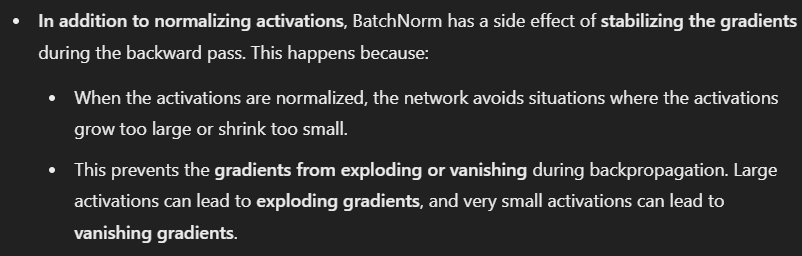

In [ ]:
# More on why the size of activations influences the gradients on the ipynb on backprop.